In [2]:
import os, warnings
from pathlib import Path

import anndata as ad
import numpy as np
import dynamo as dyn
import spateo as st
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

2023-09-19 12:15:42.428150: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-19 12:15:42.450132: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-19 12:15:42.795932: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from typing import Optional, Tuple, Union

import matplotlib as mpl
import numpy as np
from pyvista import PolyData, UniformGrid, UnstructuredGrid

try:
    from typing import Literal
except ImportError:
    from typing_extensions import Literal


def add_model_labels(
        model: Union[PolyData, UnstructuredGrid, UniformGrid],
        labels: np.ndarray,
        key_added: str = "groups",
        where: Literal["point_data", "cell_data"] = "cell_data",
        colormap: Union[str, list, dict, np.ndarray] = "rainbow",
        alphamap: Union[float, list, dict, np.ndarray] = 1.0,
        mask_color: Optional[str] = "gainsboro",
        mask_alpha: Optional[float] = 0.0,
        inplace: bool = False,
) -> Tuple[Optional[PolyData or UnstructuredGrid], Optional[Union[str]]]:
    model = model.copy() if not inplace else model
    labels = np.asarray(labels).flatten()

    cu_arr = np.sort(np.unique(labels), axis=0).astype(object)
    raw_labels_hex = labels.copy().astype(object)
    raw_labels_alpha = labels.copy().astype(object)
    raw_labels_hex[raw_labels_hex == "mask"] = mpl.colors.to_hex(mask_color)
    raw_labels_alpha[raw_labels_alpha == "mask"] = mask_alpha

    # Set raw hex.
    if isinstance(colormap, str):
        if colormap in list(mpl.colormaps()):
            lscmap = mpl.cm.get_cmap(colormap)
            raw_hex_list = [mpl.colors.to_hex(lscmap(i)) for i in np.linspace(0, 1, len(cu_arr))]
            for label, color in zip(cu_arr, raw_hex_list):
                raw_labels_hex[raw_labels_hex == label] = color
        else:
            raw_labels_hex[raw_labels_hex != "mask"] = mpl.colors.to_hex(colormap)
    elif isinstance(colormap, dict):
        for label, color in colormap.items():
            raw_labels_hex[raw_labels_hex == label] = mpl.colors.to_hex(color)
    elif isinstance(colormap, list) or isinstance(colormap, np.ndarray):
        raw_hex_list = np.array([mpl.colors.to_hex(color) for color in colormap]).astype(object)
        for label, color in zip(cu_arr, raw_hex_list):
            raw_labels_hex[raw_labels_hex == label] = color
    else:
        raise ValueError("`colormap` value is wrong." "\nAvailable `colormap` types are: `str`, `list` and `dict`.")

    # Set raw alpha.
    if isinstance(alphamap, float) or isinstance(alphamap, int):
        raw_labels_alpha[raw_labels_alpha != "mask"] = alphamap
    elif isinstance(alphamap, dict):
        for label, alpha in alphamap.items():
            raw_labels_alpha[raw_labels_alpha == label] = alpha
    elif isinstance(alphamap, list) or isinstance(alphamap, np.ndarray):
        raw_labels_alpha = np.asarray(alphamap).astype(object)
    else:
        raise ValueError(
            "`alphamap` value is wrong." "\nAvailable `alphamap` types are: `float`, `list` and `dict`."
        )

    # Set rgba.
    labels_rgba = [mpl.colors.to_rgba(c, alpha=a) for c, a in zip(raw_labels_hex, raw_labels_alpha)]
    labels_rgba = np.array(labels_rgba).astype(np.float32)

    # Added rgba of the labels.
    if where == "point_data":
        model.point_data[f"{key_added}_rgba"] = labels_rgba
    else:
        model.cell_data[f"{key_added}_rgba"] = labels_rgba

    plot_cmap = None

    # Added labels.
    if where == "point_data":
        model.point_data[key_added] = labels
    else:
        model.cell_data[key_added] = labels

    return model if not inplace else None, plot_cmap

## Load the data

In [5]:
sample_id = "E7_8h"
os.chdir(f"/media/pc001/Yao/Projects/Project_drosophila/Data_v4/migration-hotspot/drosophila_{sample_id}_germ_layer_new")
cpo = [(41, 1209, 57), (13, 8, -3), (0, 0, 1)]

out_image_path = f"image/germband_migration_region/midgut_muscle_migration"
Path(out_image_path).mkdir(parents=True, exist_ok=True)

In [6]:
germ_adata = st.read_h5ad(f"h5ad/{sample_id}_germband_v4.h5ad")

germ_pc = st.tdr.read_model(f"morpho_models/germband_morphometrics_pc_model.vtk")
germ_mesh = st.tdr.read_model(f"morpho_models/germband_morphometrics_mesh_model.vtk")
trajectory_model = st.tdr.read_model(f"morpho_models/germband_morphofield_trajectory_model.vtk")
germ_adata

AnnData object with n_obs × n_vars = 12585 × 8120
    obs: 'area', 'slices', 'anno_cell_type', 'anno_tissue', 'anno_germ_layer', 'actual_stage', 'scc', 'anno_tissue_new', 'V_z', 'anno_germ_layer_new', 'backbone_nodes', 'backbone_scc', 'segments', 'morpho_acceleration', 'morpho_curvature', 'morpho_curl', 'morpho_torsion'
    uns: 'VecFld_morpho', 'glm_degs', 'log1p', 'pp'
    obsm: '2d_realign_spatial', '3d_align_spatial', 'V_cells_mapping', 'X_cells_mapping', 'X_pca', 'X_umap', 'morpho_acceleration', 'morpho_curl', 'morpho_curvature', 'morpho_velocity', 'raw_spatial', 'tdr_spatial'
    layers: 'X_counts', 'spliced', 'unspliced'

## Highly-migrated region of muscle and midgut

In [7]:
hm_adata = germ_adata[germ_adata.obs["anno_tissue_new"].isin(["midgut", "muscle"]), :]
hm_adata = hm_adata[hm_adata.layers["X_counts"].sum(axis=1) !=0, hm_adata.layers["X_counts"].sum(axis=0) !=0]

hm_pc, _ = st.tdr.construct_pc(
    adata=hm_adata, spatial_key="3d_align_spatial", groupby="anno_tissue_new", key_added="tissue",
    colormap={"CNS": "#ea5545", "hindgut": "#27aeef", "midgut": "#87bc45", "muscle": "#f46a9b", "salivary gland": "#ef9b20",}
)
trajectory_model = trajectory_model.extract_points(list(map(lambda x: x in hm_adata.obs.index, np.asarray(trajectory_model.point_data["obs_index"]))))
hm_adata

View of AnnData object with n_obs × n_vars = 7285 × 8050
    obs: 'area', 'slices', 'anno_cell_type', 'anno_tissue', 'anno_germ_layer', 'actual_stage', 'scc', 'anno_tissue_new', 'V_z', 'anno_germ_layer_new', 'backbone_nodes', 'backbone_scc', 'segments', 'morpho_acceleration', 'morpho_curvature', 'morpho_curl', 'morpho_torsion'
    uns: 'VecFld_morpho', 'glm_degs', 'log1p', 'pp'
    obsm: '2d_realign_spatial', '3d_align_spatial', 'V_cells_mapping', 'X_cells_mapping', 'X_pca', 'X_umap', 'morpho_acceleration', 'morpho_curl', 'morpho_curvature', 'morpho_velocity', 'raw_spatial', 'tdr_spatial'
    layers: 'X_counts', 'spliced', 'unspliced'

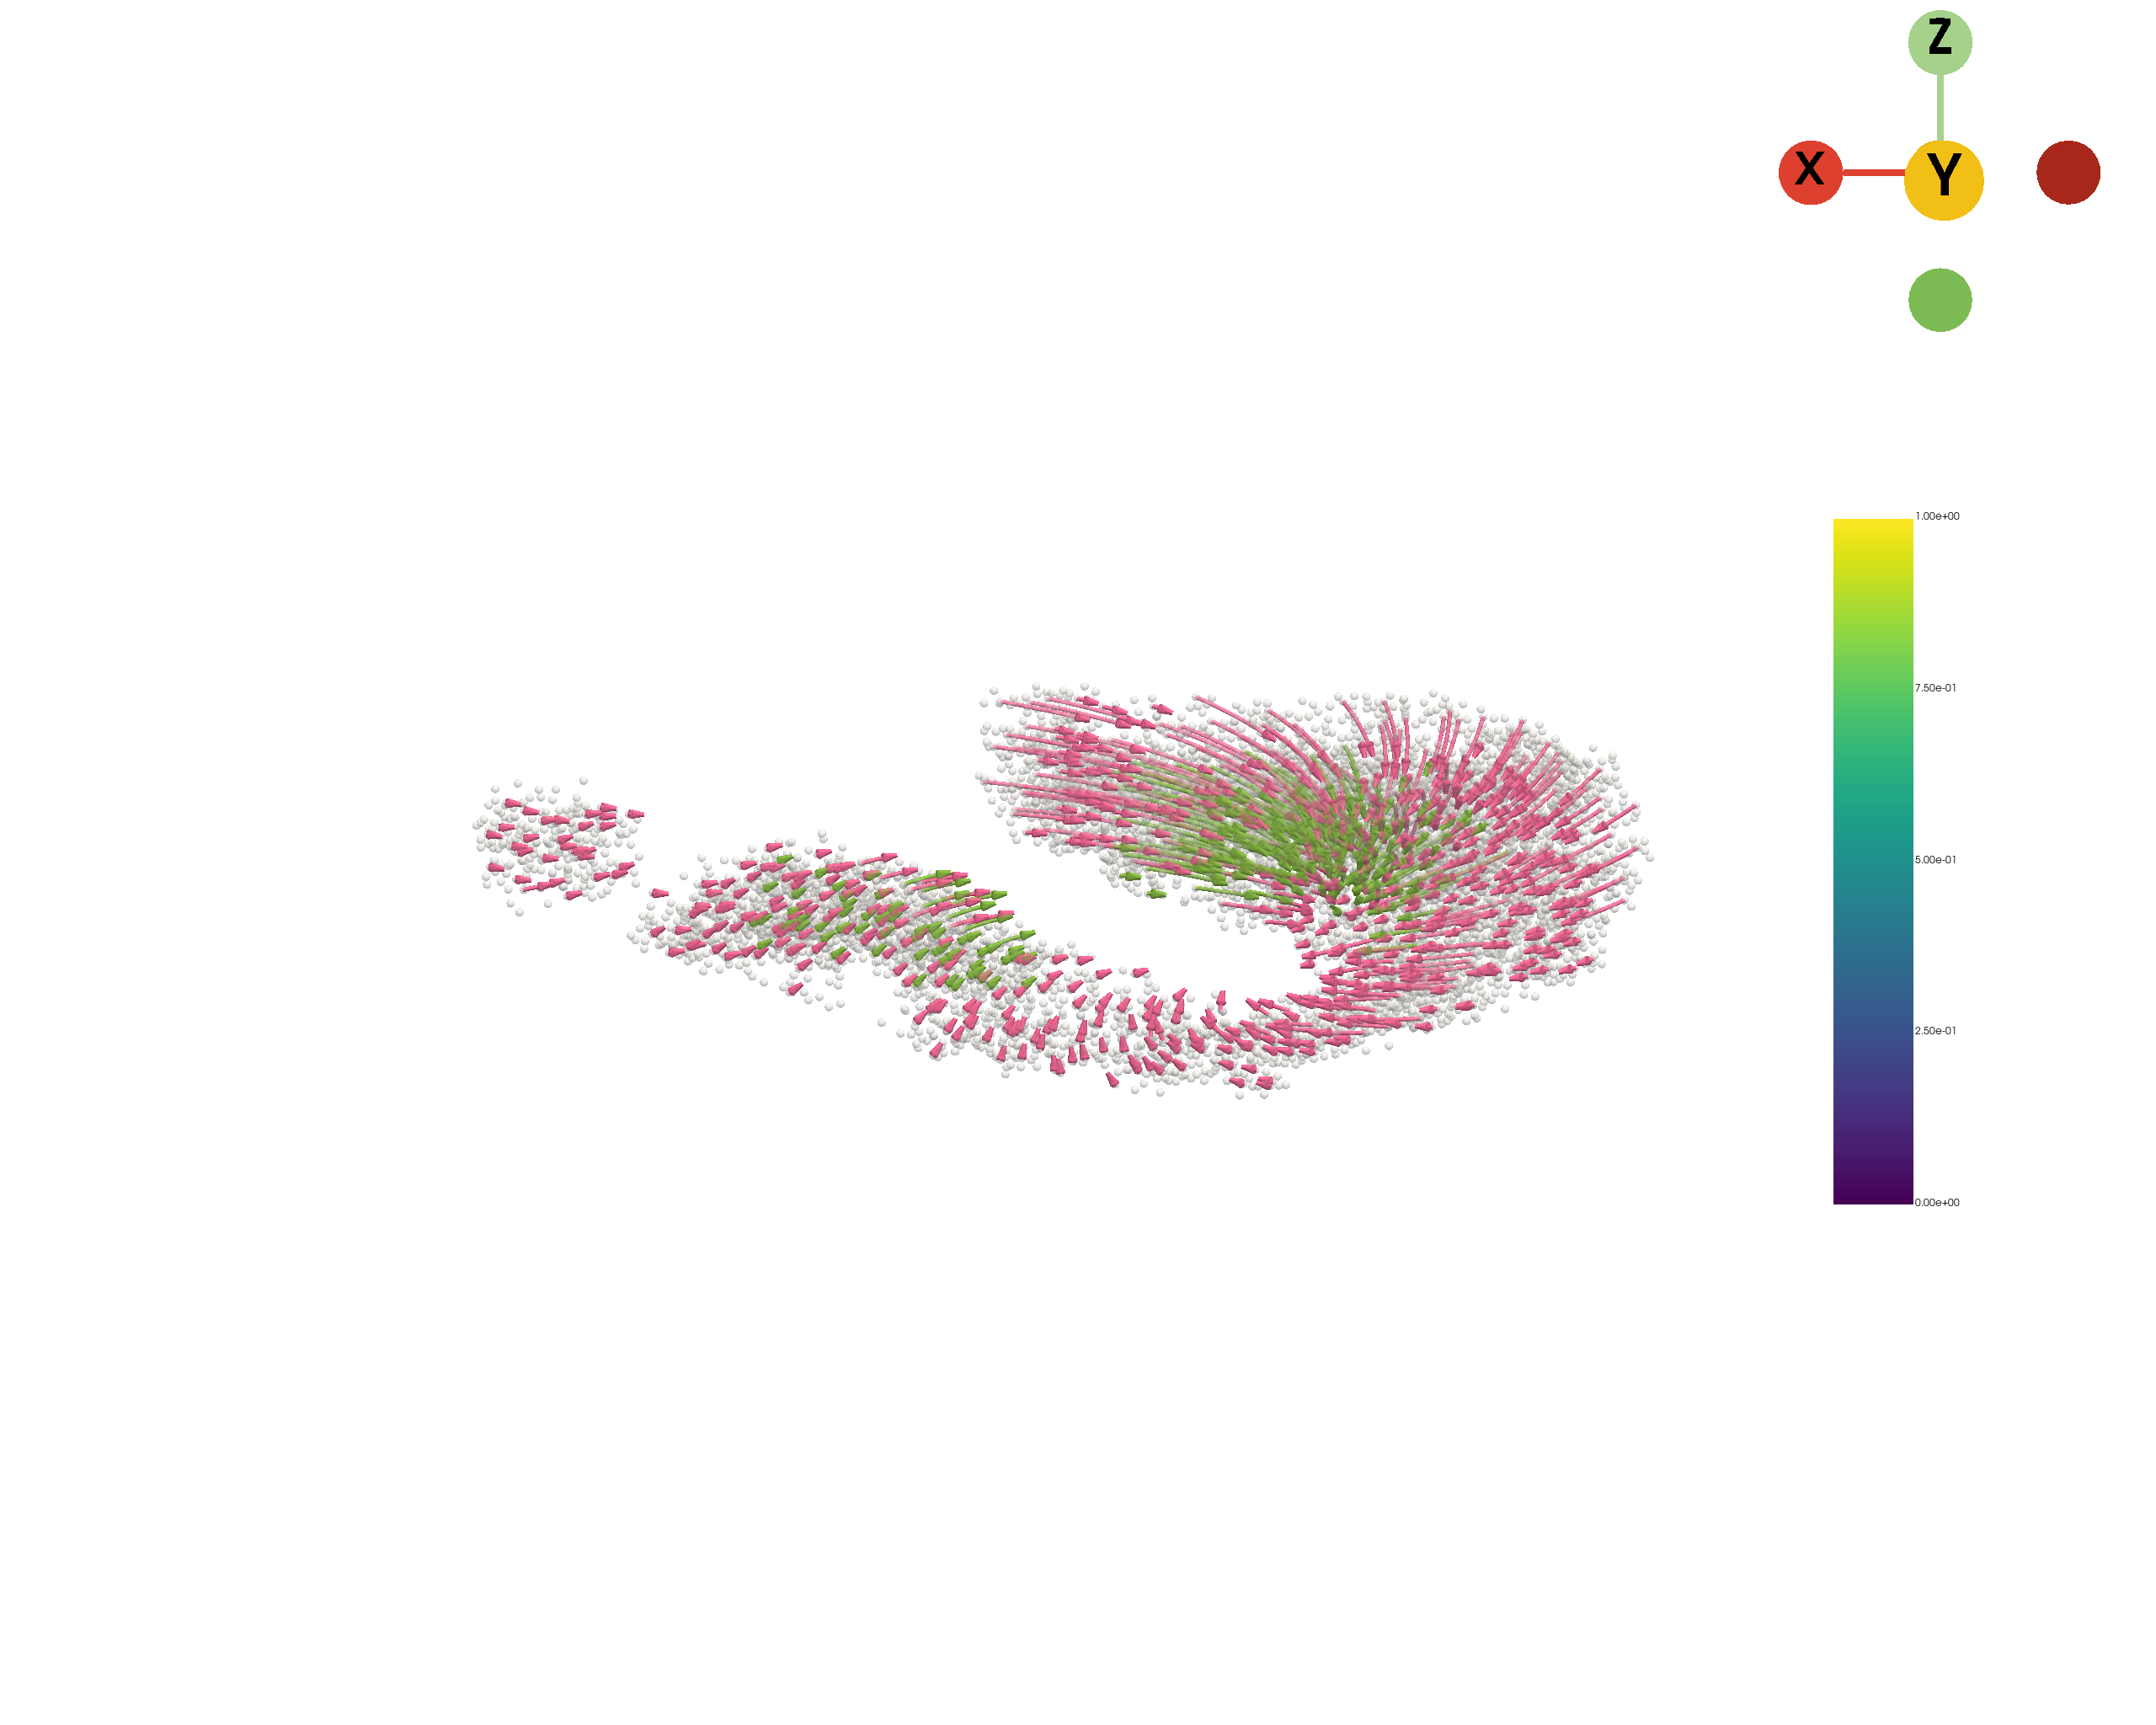

In [8]:
st.tdr.add_model_labels(
    model=trajectory_model,
    key_added="tissue",
    labels=np.asarray(hm_adata[np.asarray(trajectory_model.point_data["obs_index"])].obs["anno_tissue_new"]),
    colormap={"CNS": "#ea5545", "hindgut": "#27aeef", "midgut": "#87bc45", "muscle": "#f46a9b", "salivary gland": "#ef9b20",},
    where="point_data",
    inplace=True,
)
st.pl.three_d_plot(
    model=st.tdr.collect_models([hm_pc, trajectory_model]),
    key=["tissue", "tissue"],
    opacity=[0.5, .5],
    model_style=["points", "wireframe"],
    model_size=[10, 5],
    colormap=["gainsboro", None],
    jupyter="static",
    background="white",
    window_size=(2560, 2048),
    cpo=cpo,
    filename=os.path.join(out_image_path, f"{sample_id}_midgut_muscle_trajectory_model.pdf"),
)

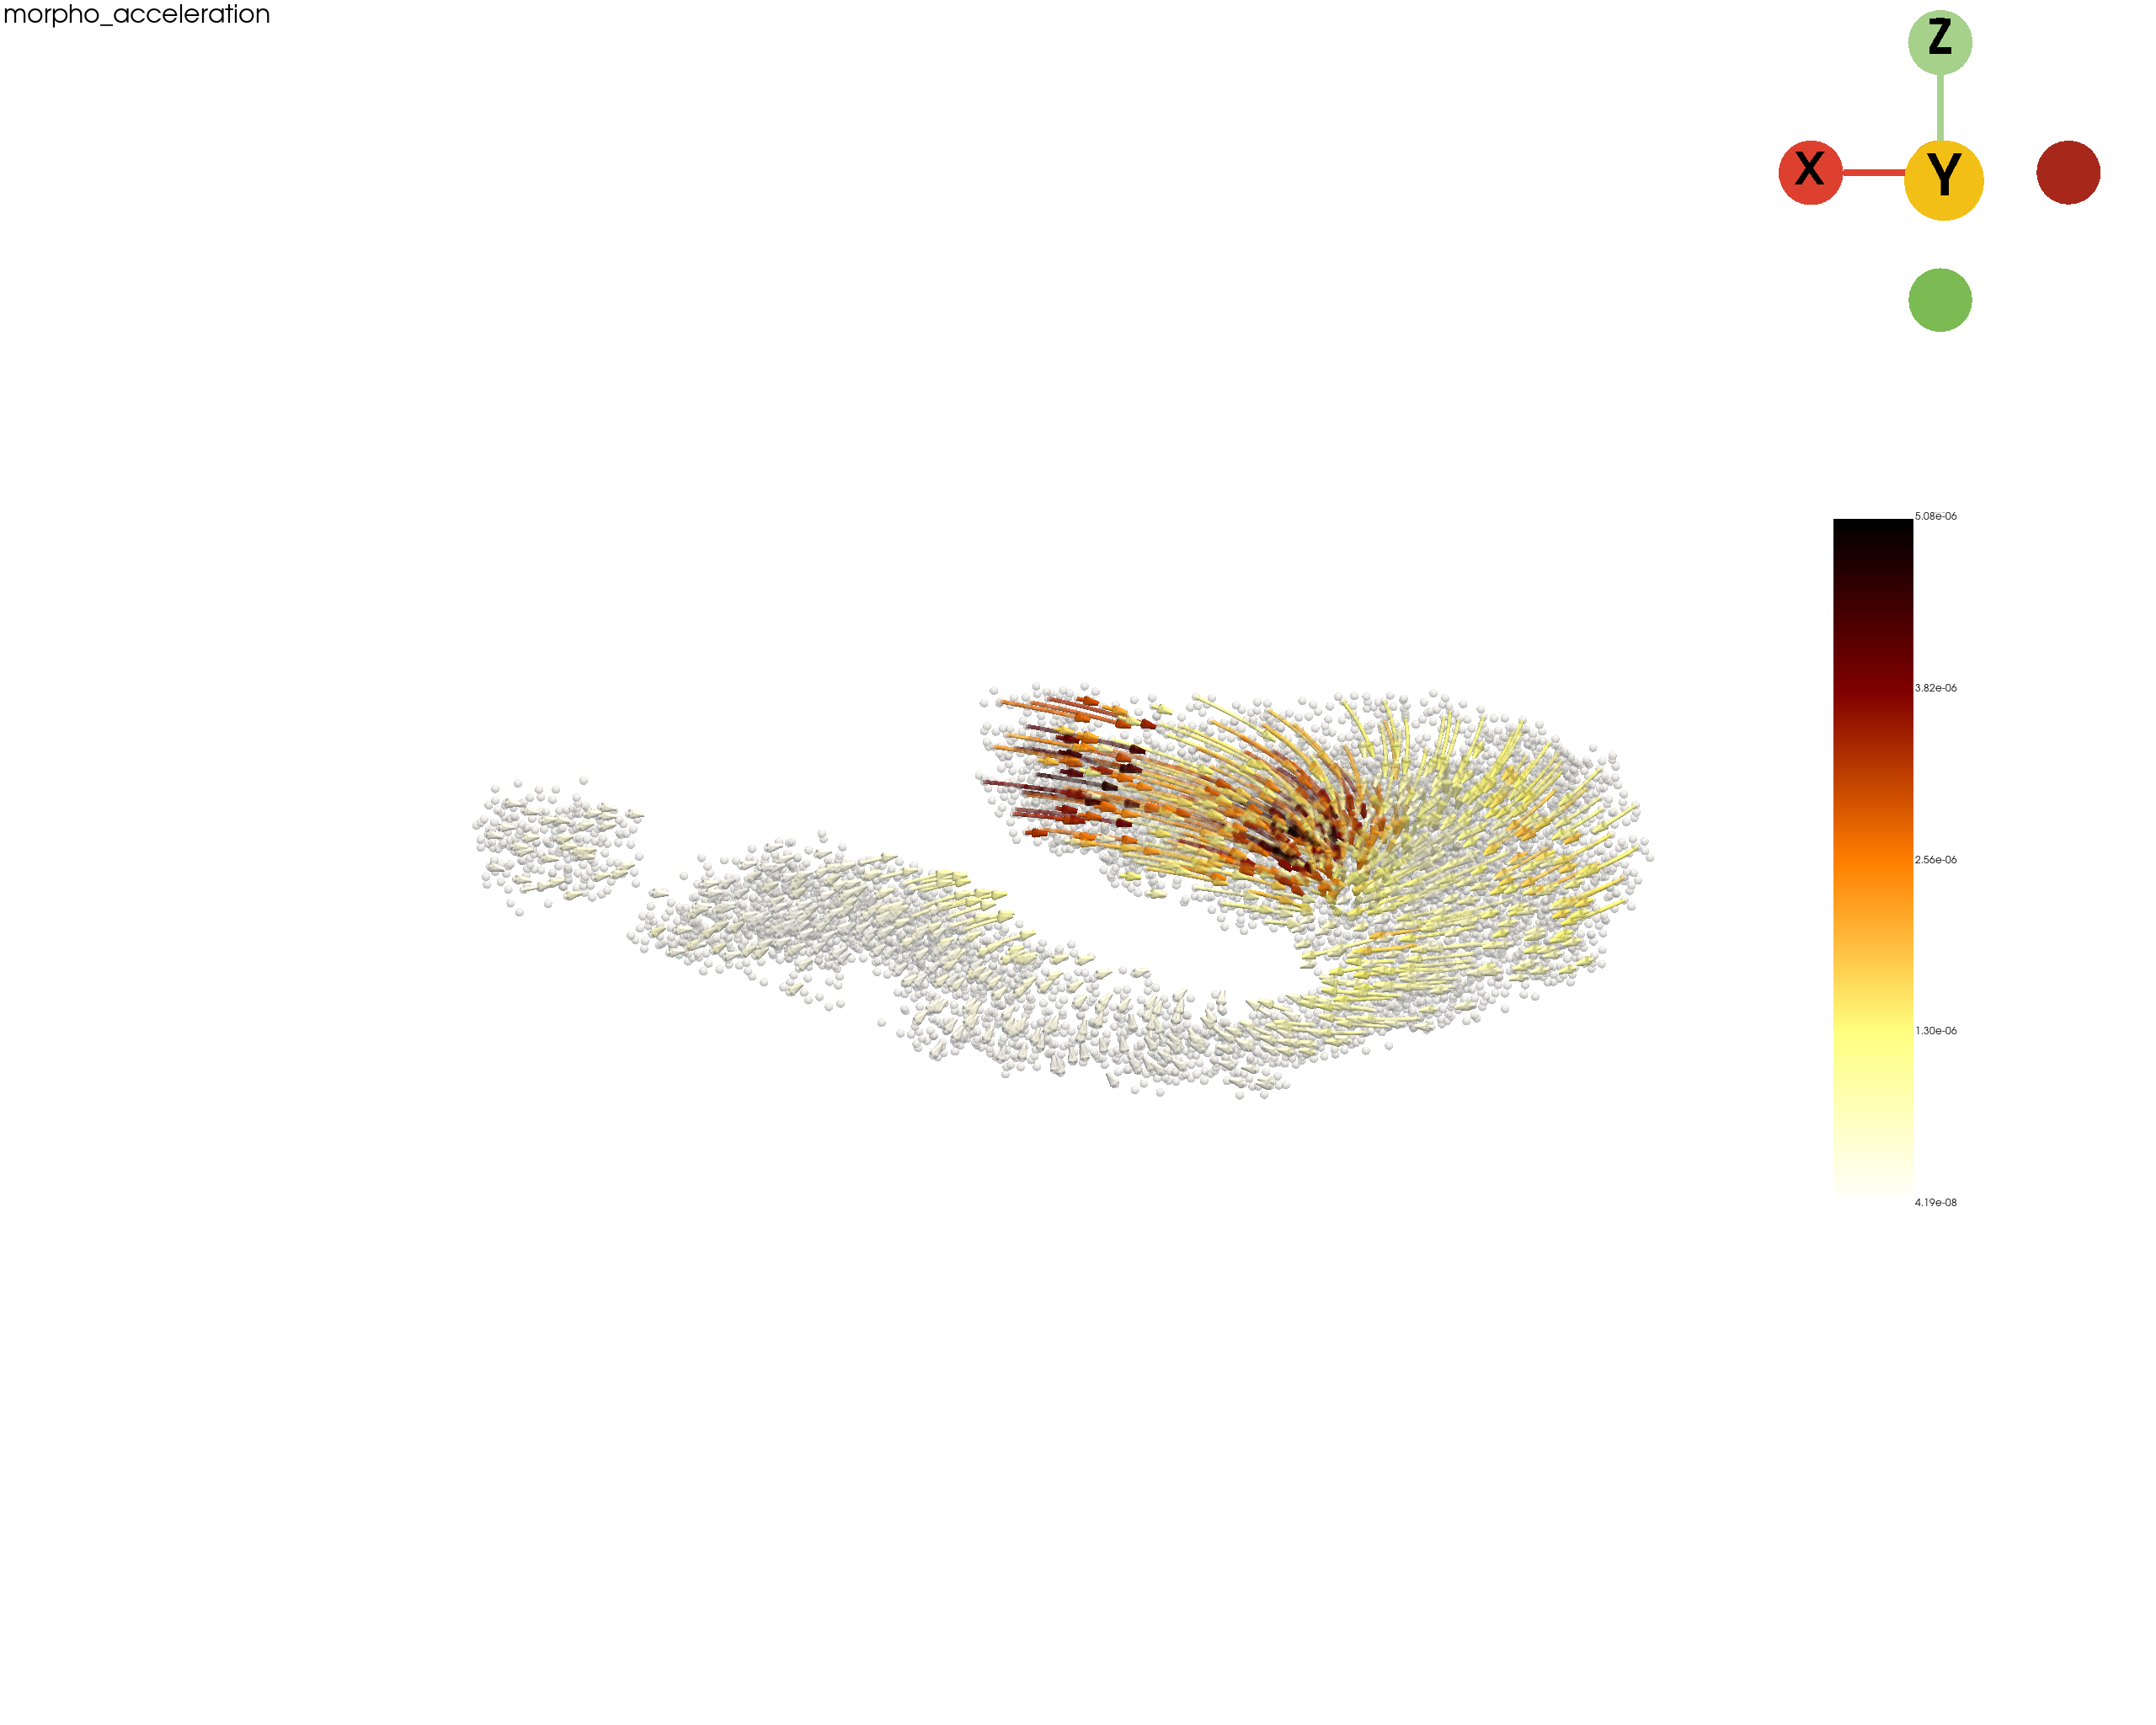

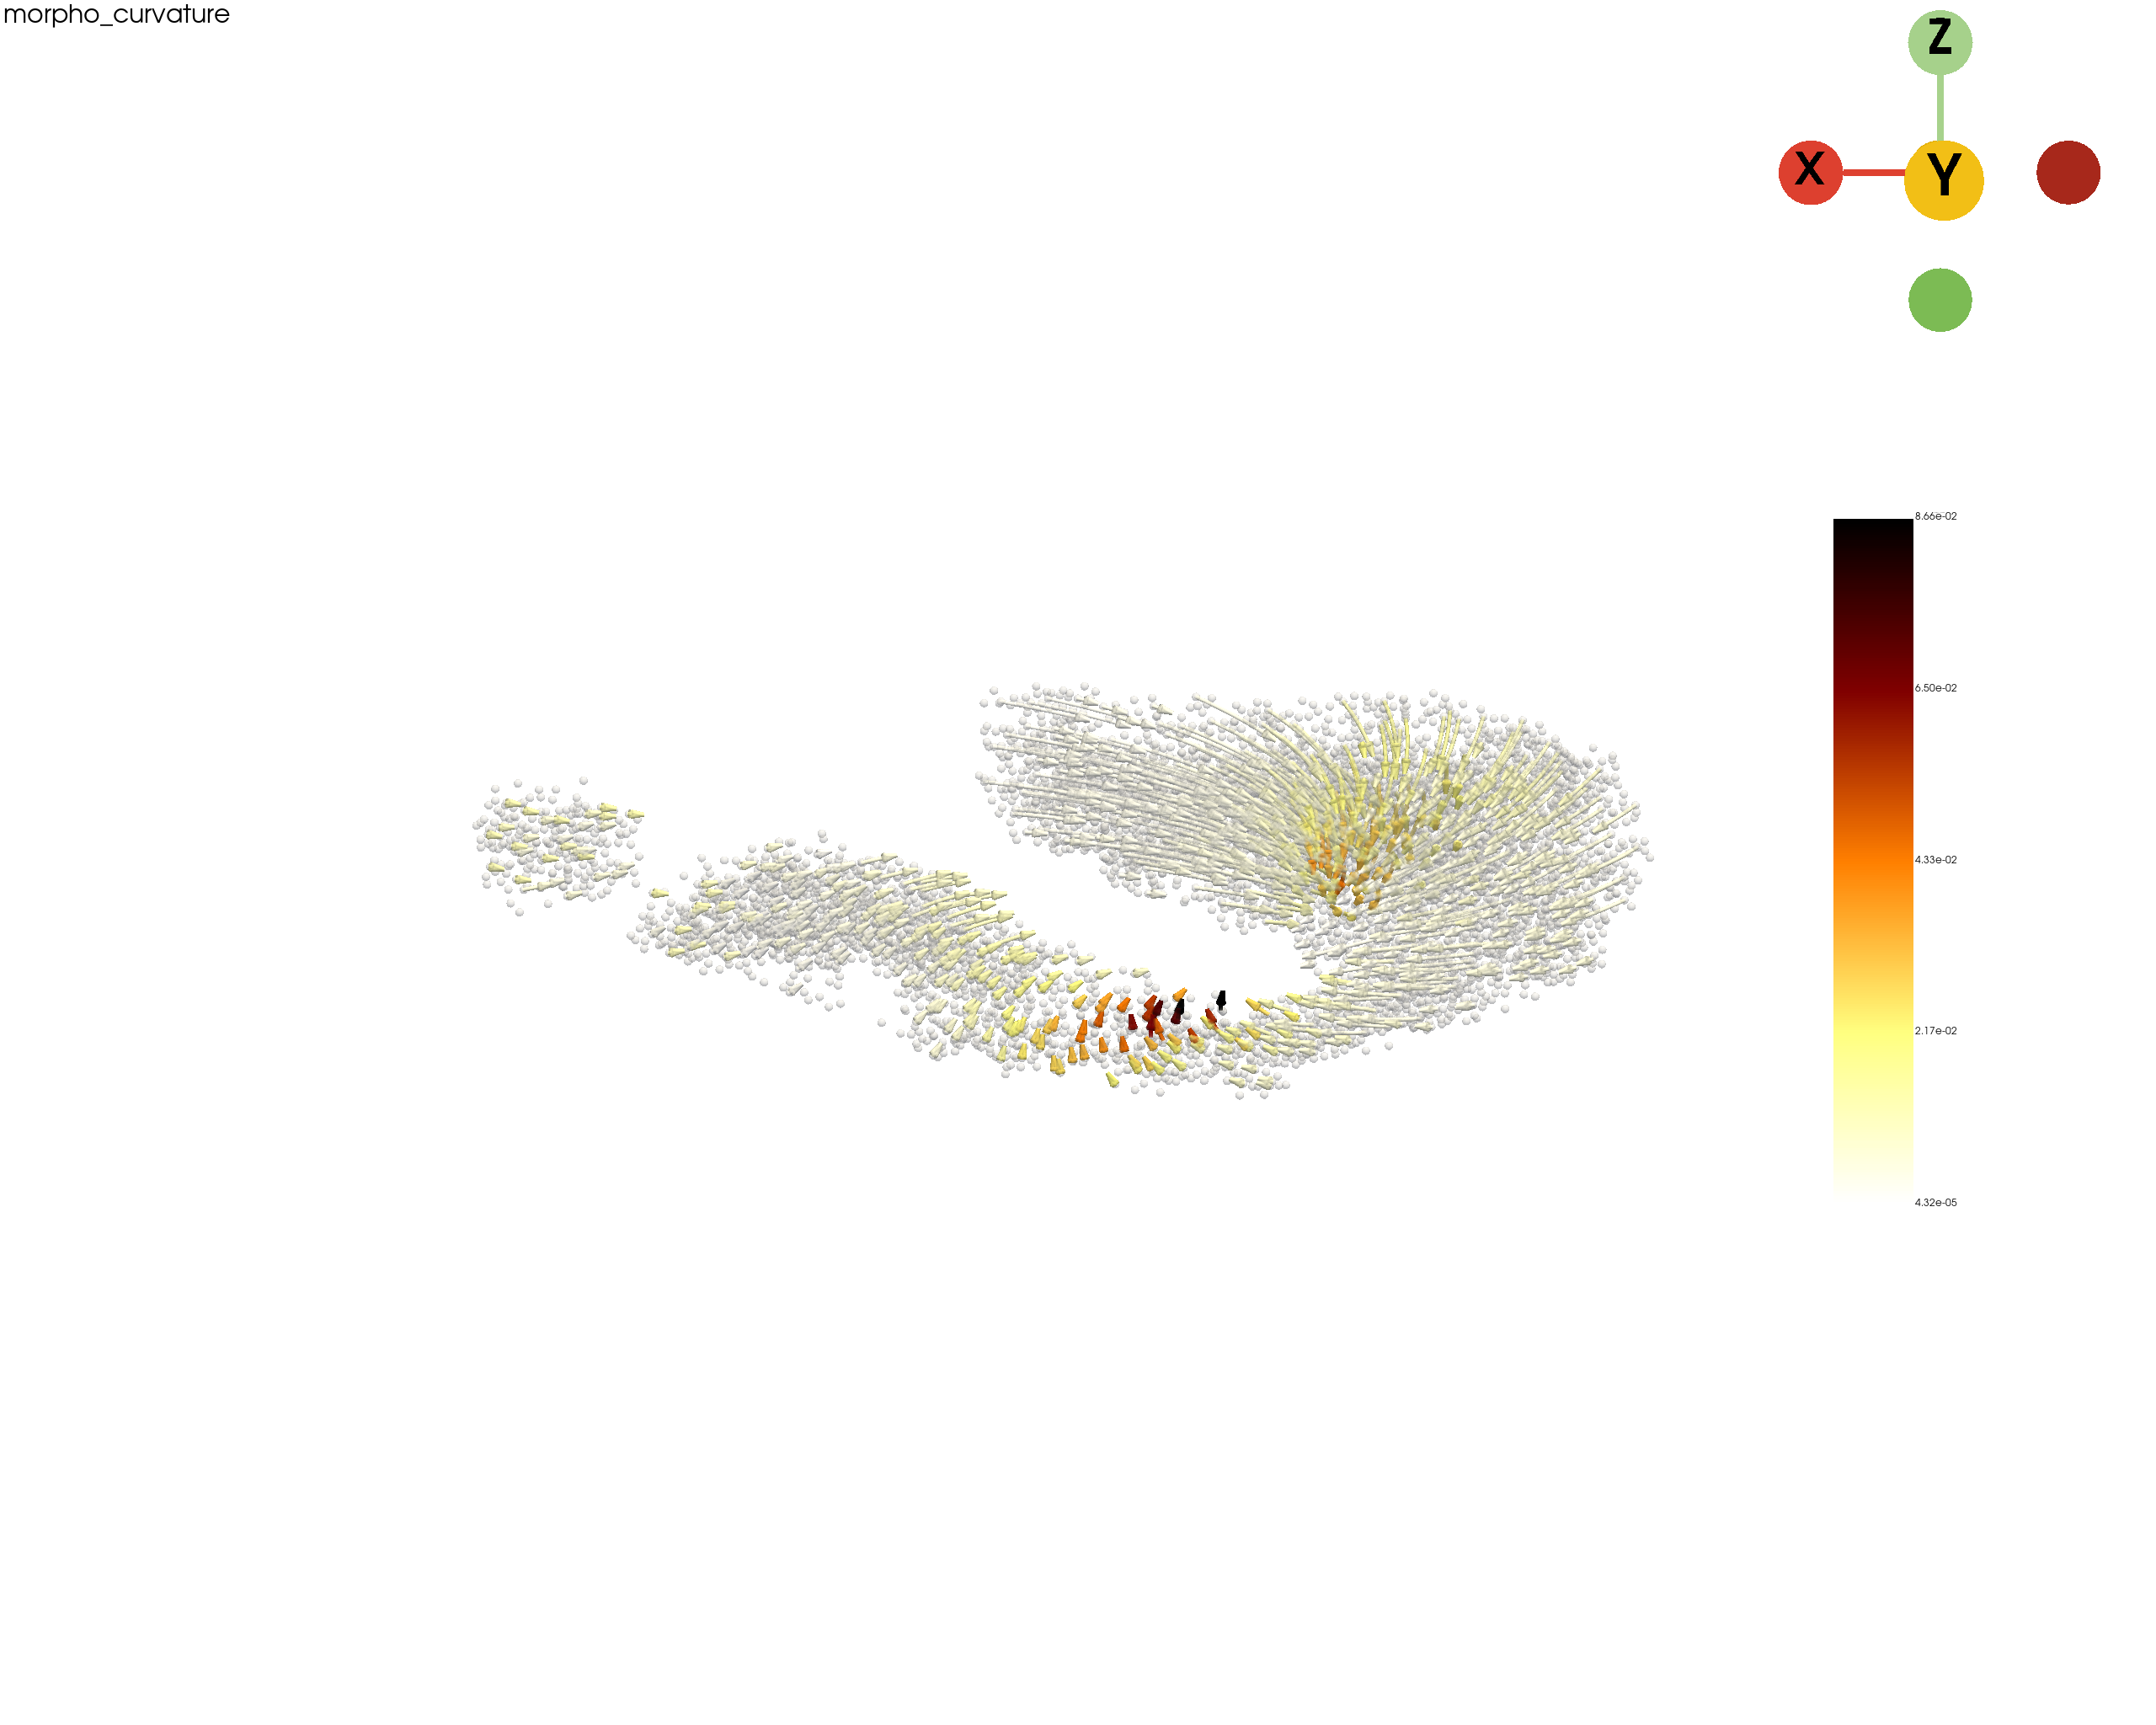

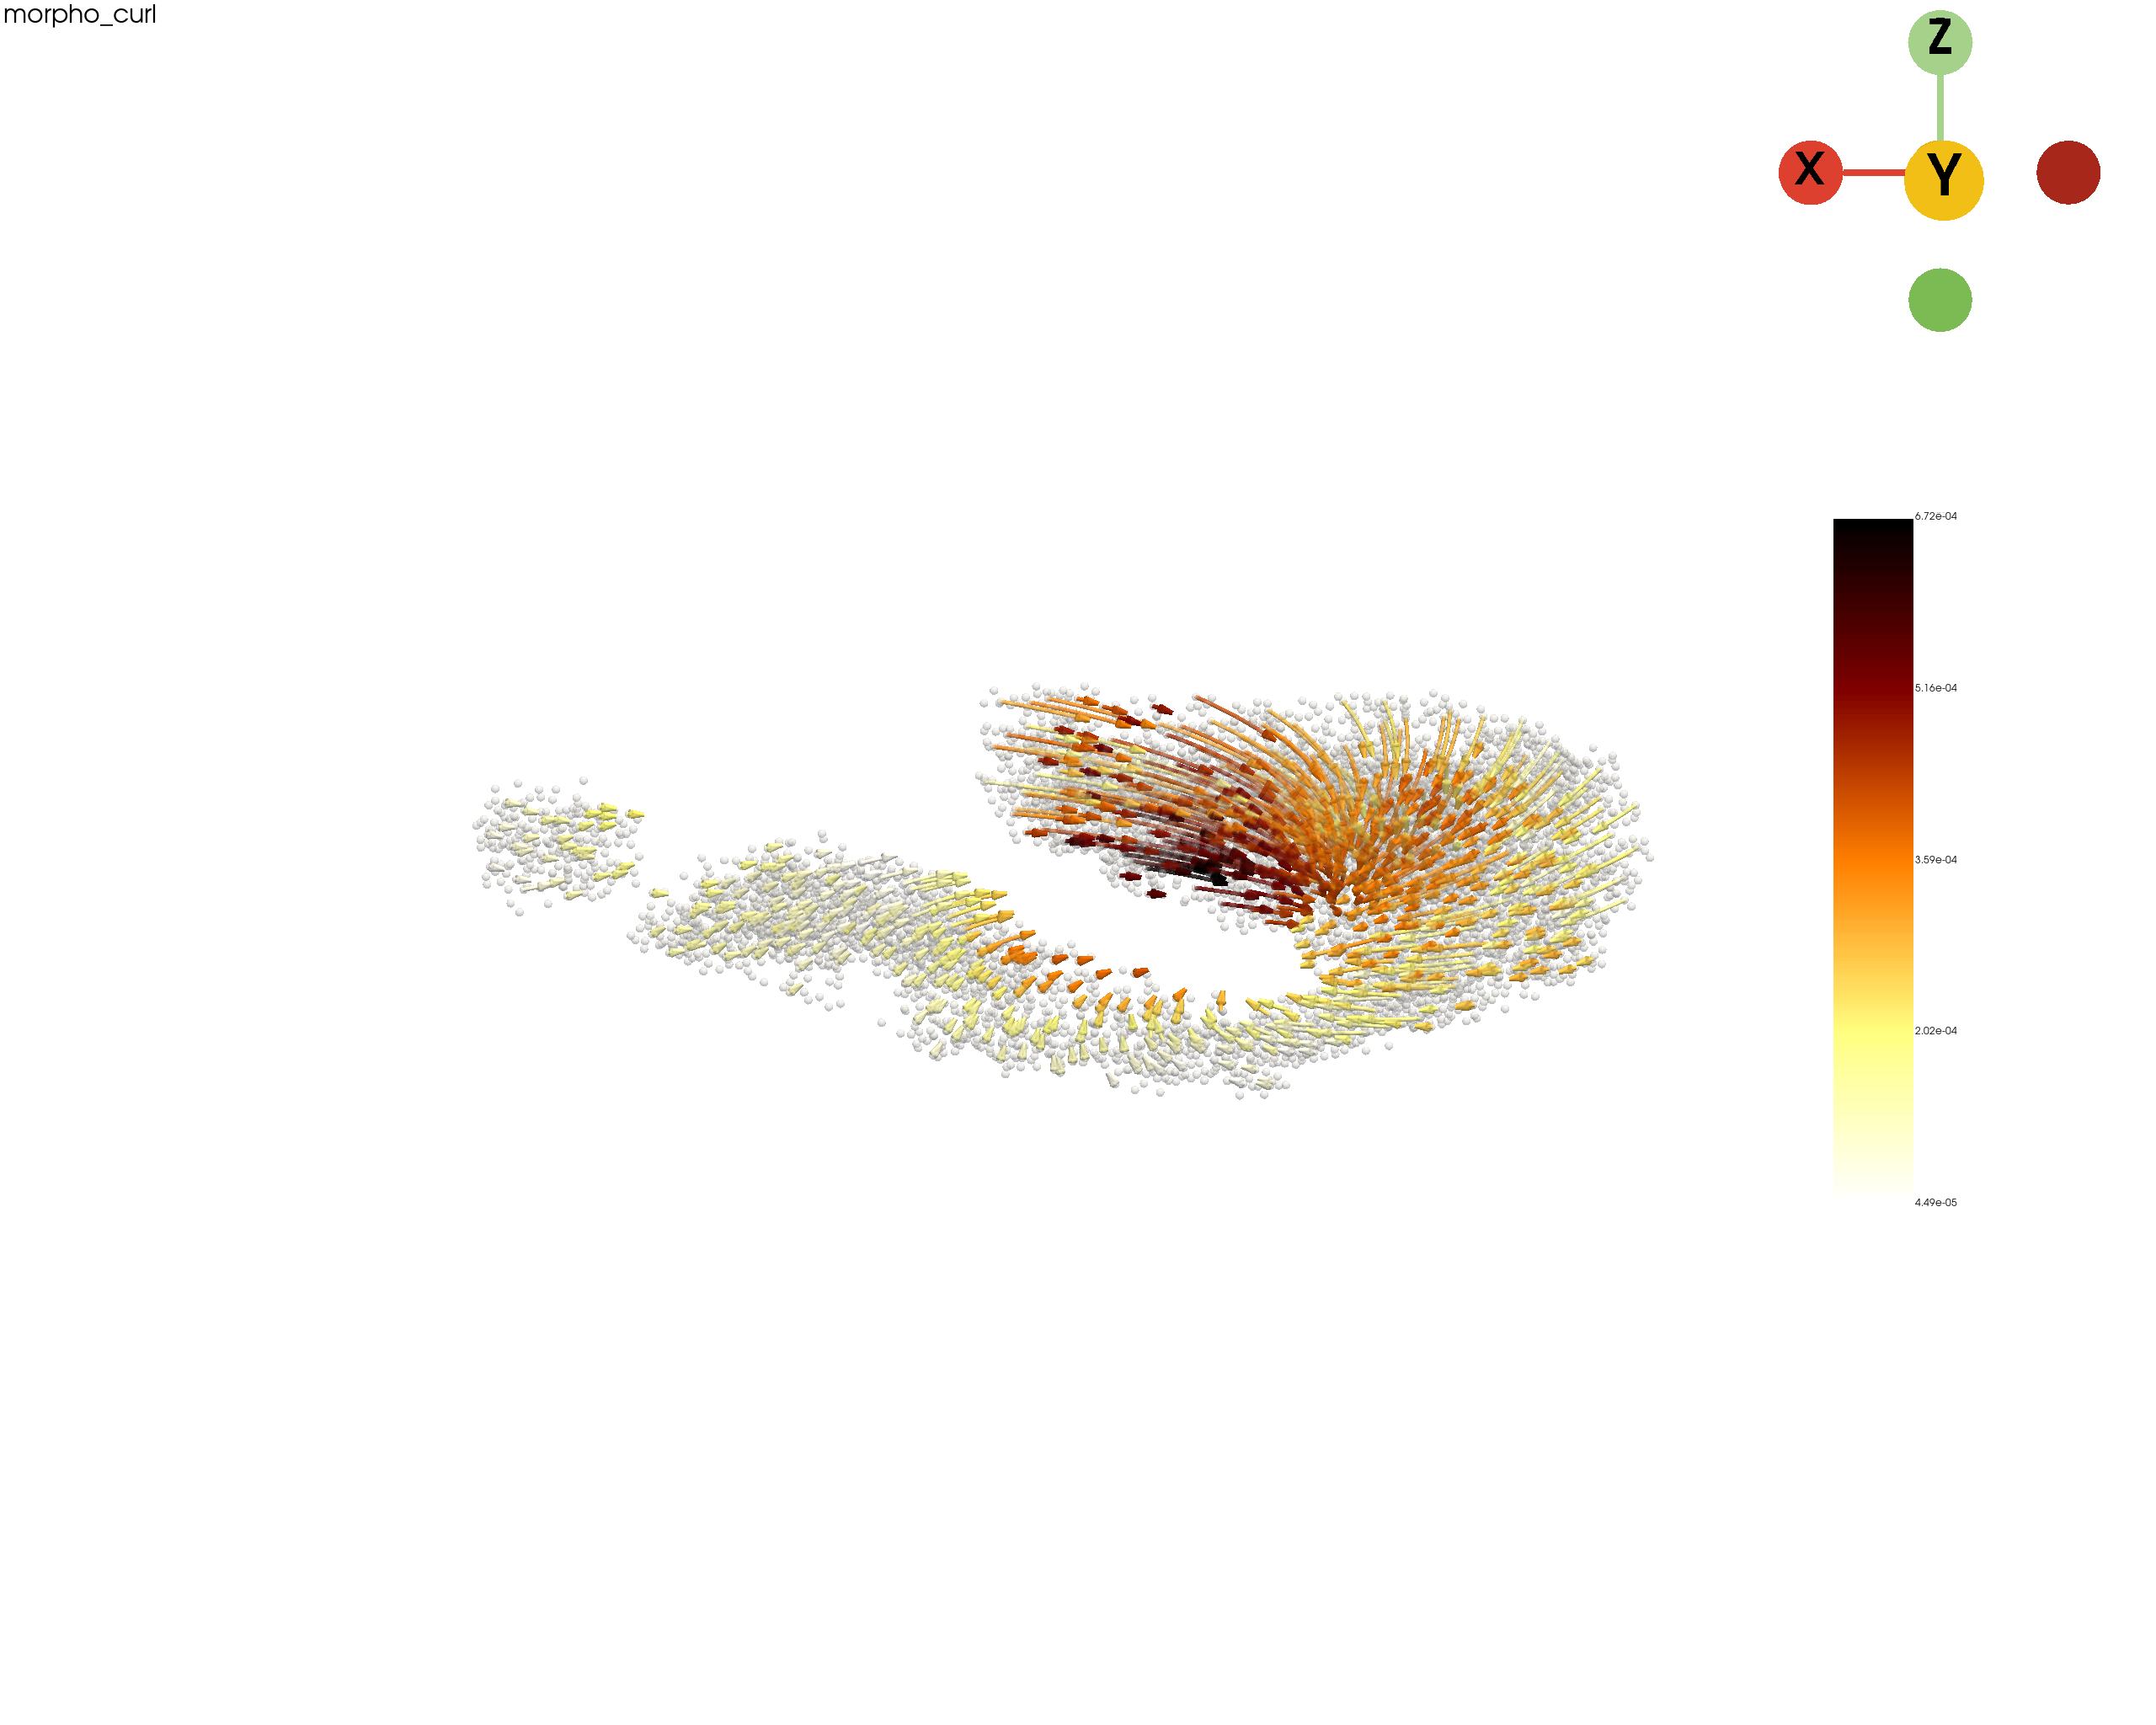

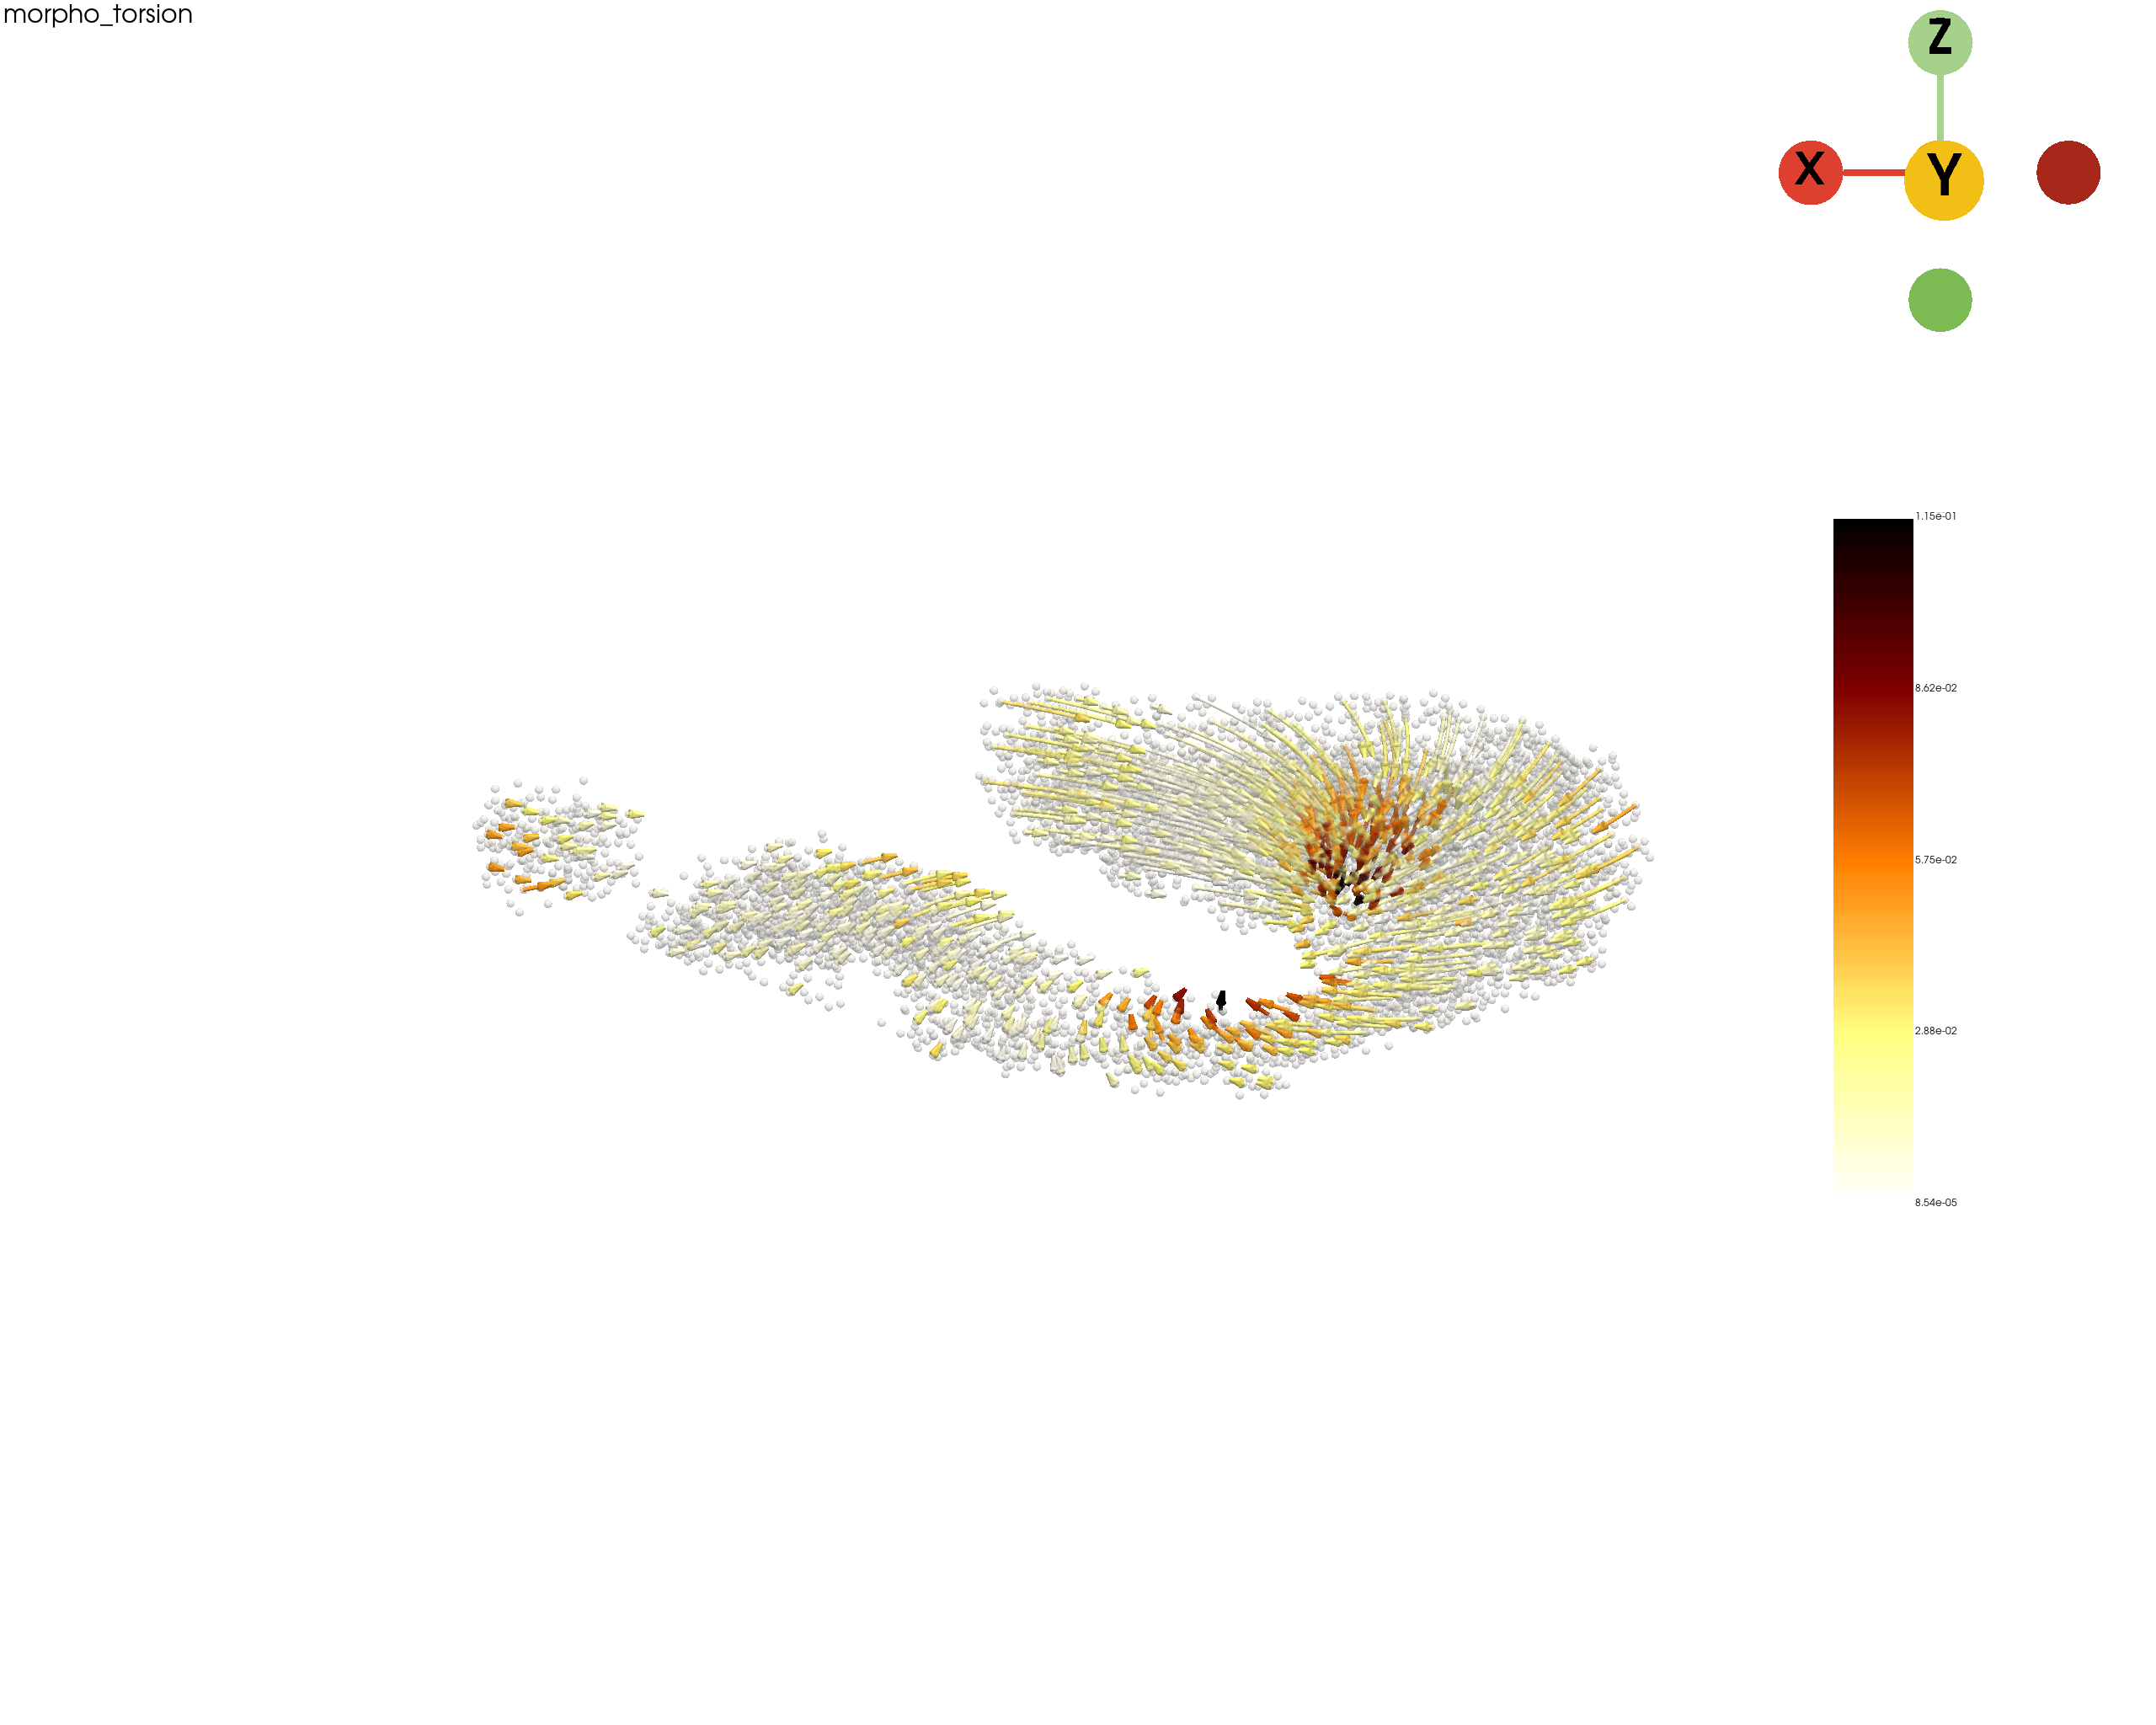

In [9]:
morphometrics_keys = ["morpho_acceleration", "morpho_curvature", "morpho_curl", "morpho_torsion"]
for mk in morphometrics_keys:
    mmvalue = hm_adata[hm_pc.point_data["obs_index"].tolist(), :].obs[mk].values
    st.tdr.add_model_labels(model=hm_pc, labels=mmvalue, key_added=mk, where="point_data",inplace=True, colormap="afmhot_r")
    
    st.tdr.add_model_labels(
        model=trajectory_model,
        key_added=mk,
        labels=np.asarray(hm_adata[np.asarray(trajectory_model.point_data["obs_index"])].obs[mk]),
        where="point_data",
        inplace=True,
    )
    
    st.pl.three_d_plot(
        model=st.tdr.collect_models([hm_pc, trajectory_model]),
        key=["tissue", mk],
        model_style=["points", "wireframe"],
        model_size=[10, 5],
        opacity=[0.5, 0.5],
        colormap=["gainsboro", "afmhot_r"],
        show_legend=True,
        jupyter="static",
        off_screen=True,
        background="white",
        cpo=cpo,
        window_size=(2560, 2048),
        text=mk,
        filename=os.path.join(out_image_path, f"{sample_id}_midgut_muscle_{mk}_pc_trajectory_model.pdf"),
    )

## GLM of curl

In [11]:
hm_adata.X= hm_adata.layers["X_counts"].copy()
sc.pp.normalize_total(hm_adata)
sc.pp.log1p(hm_adata)
st.tl.glm_degs(
    adata=hm_adata,
    fullModelFormulaStr=f'~cr(morpho_curl, df=3)',
    key_added="glm_degs",
    qval_threshold=1e-3,
    llf_threshold=-100,
)
print(hm_adata.uns["glm_degs"]["glm_result"])

|-----? Gene expression matrix must be normalized by the size factor, please check if the input gene expression matrix is correct.If you don't have the size factor normalized gene expression matrix, please run `dynamo.pp.normalize_cell_expr_by_size_factors(skip_log = True)`.
|-----> [Detecting genes via Generalized Additive Models (GAMs)] in progress: 100.0000%
|-----> [Detecting genes via Generalized Additive Models (GAMs)] finished [778.8442s]
                    status family  log-likelihood          pval          qval
Acbp5                   ok    NB2     -432.465637  7.954414e-25  6.403304e-21
Cys                     ok    NB2    -6358.817871  4.726220e-18  1.507165e-14
Rbfox1                  ok    NB2    -2045.220093  5.616763e-18  1.507165e-14
hth                     ok    NB2    -1964.313843  6.716808e-17  1.351758e-13
Act57B                  ok    NB2    -3367.151611  1.084785e-15  1.746504e-12
Abd-B                   ok    NB2     -487.868713  1.957348e-15  2.626109e-12
Gmap

In [28]:
glm_data = hm_adata.uns["glm_degs"]["glm_result"]
glm_data= glm_data.loc[glm_data["log-likelihood"] >= -5000, :]
# glm_data= glm_data.loc[glm_data["pval"] <= 1e-5, :]
selected_genes = list(glm_data.index)
glm_data

status family  log-likelihood          pval          qval
Acbp5                ok    NB2     -432.465637  7.954414e-25  6.403304e-21
Rbfox1               ok    NB2    -2045.220093  5.616763e-18  1.507165e-14
hth                  ok    NB2    -1964.313843  6.716808e-17  1.351758e-13
Act57B               ok    NB2    -3367.151611  1.084785e-15  1.746504e-12
Abd-B                ok    NB2     -487.868713  1.957348e-15  2.626109e-12
Gmap                 ok    NB2    -1297.005859  3.204987e-14  3.685735e-11
Mef2                 ok    NB2    -2502.309814  2.722550e-13  2.739566e-10
Ance                 ok    NB2    -2633.844238  1.421455e-12  1.271412e-09
abd-A                ok    NB2     -697.711548  1.819005e-12  1.464299e-09
Ubx                  ok    NB2     -640.291382  5.135433e-12  3.758204e-09
lmd                  ok    NB2    -1294.690308  5.610800e-12  3.763911e-09
CG9674               ok    NB2    -1171.193848  6.310250e-12  3.907501e-09
betaTub60D           ok    NB2    -2873.030029  1.102315e-11  6.338312e-09
COX8                 ok    NB2    -4082.462158  1.918960e-11  1.029842e-08
Cp1                  ok    NB2    -2499.700439  1.032883e-10  5.196692e-08
E(spl)m3-HLH         ok    NB2    -1188.157959  1.133468e-10  5.367304e-08
Pka-C3               ok    NB2     -761.431763  1.331326e-10  5.953986e-08
Npc2g                ok    NB2     -816.188477  1.083996e-09  4.592721e-07
fkh                  ok    NB2     -615.694458  1.538786e-09  6.193615e-07
Gs1                  ok    NB2    -1527.326782  3.139935e-09  1.203642e-06
how                  ok    NB2    -1386.444702  3.584493e-09  1.311599e-06
asRNA:CR45108        ok    NB2     -238.094666  5.954465e-09  1.997227e-06
CG14687              ok    NB2    -2058.447021  7.147063e-09  2.301354e-06
CG32425              ok    NB2     -990.574219  1.858185e-08  5.540145e-06
CG42806              ok    NB2    -2169.616699  2.298983e-08  6.609577e-06
sns                  ok    NB2    -1642.202026  2.397991e-08  6.656492e-06
Rab32                ok    NB2     -204.597443  3.417506e-08  9.062115e-06
awd                  ok    NB2    -3740.977783  3.489759e-08  9.062115e-06
bol                  ok    NB2    -2007.358276  7.509709e-08  1.889161e-05
lncRNA:CR30009       ok    NB2    -1432.782471  8.709551e-08  2.124603e-05
lncRNA:iab8          ok    NB2     -148.875259  1.204717e-07  2.852345e-05
neo                  ok    NB2     -172.023422  1.277036e-07  2.937184e-05
CG45050              ok    NB2    -2215.461914  1.442280e-07  3.225099e-05
CG44286              ok    NB2     -529.494141  1.719817e-07  3.741765e-05
Act87E               ok    NB2    -2616.178467  1.990320e-07  4.216336e-05
E(spl)m4-BFM         ok    NB2    -1003.664307  2.387315e-07  4.857479e-05
osp                  ok    NB2     -923.542114  2.413654e-07  4.857479e-05
bnb                  ok    NB2    -3074.644531  2.598604e-07  5.102136e-05
CG2930               ok    NB2     -236.006775  3.888911e-07  7.332358e-05
COX5B                ok    NB2    -3073.123535  3.916663e-07  7.332358e-05
coro                 ok    NB2     -727.992615  1.215117e-06  2.173709e-04
sls                  ok    NB2    -1141.122803  1.414964e-06  2.476188e-04
CG33099              ok    NB2     -372.470215  1.450274e-06  2.483980e-04
caup                 ok    NB2     -253.231857  1.637831e-06  2.690723e-04
CG2991               ok    NB2     -331.358429  2.315526e-06  3.654899e-04
hbs                  ok    NB2     -633.464172  2.420869e-06  3.747692e-04
CG4440               ok    NB2    -2511.654053  3.249691e-06  4.935852e-04
E(spl)mgamma-HLH     ok    NB2    -1096.204590  4.306543e-06  6.419939e-04
CG17839              ok    NB2     -653.310120  4.439766e-06  6.498203e-04
aqz                  ok    NB2    -2762.356201  4.623208e-06  6.645861e-04
Doc3                 ok    NB2     -139.866547  6.137034e-06  8.667214e-04
CG33993              ok    NB2     -273.217590  6.513884e-06  9.040821e-04

In [32]:
gp.get_library_name(organism="fly")

['Allele_LoF_Phenotypes_from_FlyBase_2017',
 'Allele_Phenotypes_from_FlyBase_2017',
 'Anatomy_AutoRIF',
 'Anatomy_AutoRIF_Predicted_zscore',
 'Anatomy_GeneRIF',
 'Anatomy_GeneRIF_Predicted_zscore',
 'Coexpression_Predicted_GO_Biological_Process_2018',
 'Coexpression_Predicted_GO_Cellular_Component_2018',
 'Coexpression_Predicted_GO_Molecular_Function_2018',
 'GO_Biological_Process_2018',
 'GO_Biological_Process_AutoRIF',
 'GO_Biological_Process_AutoRIF_Predicted_zscore',
 'GO_Biological_Process_GeneRIF',
 'GO_Biological_Process_GeneRIF_Predicted_zscore',
 'GO_Cellular_Component_2018',
 'GO_Cellular_Component_AutoRIF',
 'GO_Cellular_Component_AutoRIF_Predicted_zscore',
 'GO_Cellular_Component_GeneRIF',
 'GO_Cellular_Component_GeneRIF_Predicted_zscore',
 'GO_Molecular_Function_2018',
 'GO_Molecular_Function_AutoRIF',
 'GO_Molecular_Function_AutoRIF_Predicted_zscore',
 'GO_Molecular_Function_GeneRIF',
 'GO_Molecular_Function_GeneRIF_Predicted_zscore',
 'Human_Disease_from_FlyBase_2017',
 

In [33]:
import gseapy as gp
gp.get_library_name(organism="fly")
# GO-biologial process
go_folder = os.path.join(out_image_path, f"morpho_curl_GO_all")
Path(go_folder).mkdir(parents=True, exist_ok=True)

go_bp = gp.enrichr(
        gene_list=selected_genes,
        gene_sets="GO_Biological_Process_2018",
        organism="fly",
        outdir=go_folder,
        no_plot=True,
        verbose=True
)
go_bp_results = pd.read_csv(os.path.join(go_folder, f"GO_Biological_Process_2018.fly.enrichr.reports.txt"), sep="\t")
gp.barplot(go_bp_results, column='Combined Score', title='GO_Biological_Process_2018', cutoff=0.05, top_term=50, figsize=(5, 20),
            ofname=os.path.join(go_folder, f"{sample_id}_morpho_curl_go_bp_selected_barplot.pdf"))
gp.dotplot(go_bp_results, column='Combined Score', title='GO_Biological_Process_2018', cmap='viridis_r', cutoff=0.05, top_term=50, figsize=(5, 20),
            ofname=os.path.join(go_folder, f"{sample_id}_morpho_curl_go_bp_selected_dotplot.pdf"))

2023-09-19 13:07:10,776 [INFO] Run: GO_Molecular_Function_2018 
2023-09-19 13:07:15,491 [INFO] Save enrichment results for GO_Molecular_Function_2018 
2023-09-19 13:07:15,492 [INFO] Done.


In [24]:
go_bp_results = pd.read_csv(os.path.join(go_folder, f"GO_Biological_Process_2018.fly.enrichr.reports_selected.txt"), sep="\t")
gp.barplot(go_bp_results, column='Combined Score', title='GO_Biological_Process_2018', cutoff=0.05, top_term=50, figsize=(5, 10), color="black",
            ofname=os.path.join(go_folder, f"{sample_id}_morpho_curl_go_bp_selected_barplot.pdf"))
gp.dotplot(go_bp_results, column='Combined Score', title='GO_Biological_Process_2023', cmap='Spectral_r', cutoff=0.05, top_term=50, figsize=(5, 10),
            ofname=os.path.join(go_folder, f"{sample_id}_morpho_curl_go_bp_selected_dotplot.pdf"))

In [25]:
st.pl.glm_fit(
    adata=hm_adata,
    genes=selected_genes,
    ncols=5,
    feature_x="morpho_curl",
    feature_y="expression",
    glm_key="glm_degs",
    save_show_or_return="all",
    color_key="morpho_curl",
    color_key_cmap="vlag",
    save_kwargs=dict(path=os.path.join(out_image_path, f"{sample_id}_morpho_curl_morpho_curl_selected_glm_degs_fit"),
                     prefix=None, ext="pdf", dpi=100)
)

Saving figure to image/germband_migration_region/midgut_muscle_migration/E7_8h_morpho_curl_morpho_curl_selected_glm_degs_fit.pdf...
Done


In [ ]:
for gn in selected_genes:
    _gn = str(gn).replace(":", "_") if ":" in gn else gn

    out_image_genes = os.path.join(out_image_path, "curl_genes")
    Path(out_image_genes).mkdir(parents=True, exist_ok=True)

    pc_index = hm_pc.point_data["obs_index"].tolist()
    exp = hm_adata[pc_index, gn].X.A.flatten()
    exp[exp <= 0] = 0

    amap = exp.copy()
    amap = amap / np.max(amap)
    amap[amap <= 0.2] = 0.2
    add_model_labels(model=hm_pc, labels=exp, key_added=gn, alphamap=amap, where="point_data", inplace=True,
                     colormap="afmhot_r")

    st.pl.three_d_plot(
        model=hm_pc,
        key=gn,
        model_style="points",
        model_size=14,
        opacity=1,
        colormap=None,
        show_legend=True,
        jupyter="static",
        off_screen=False,
        cpo=cpo,
        window_size=(2560, 2048),
        text=gn,
        filename=os.path.join(out_image_genes, f"{sample_id}_midgut_muscle_morpho_curl_model_{_gn}.pdf")
    )

In [10]:
increased_genes = [
    "Acbp5", "Abd-B", "Gmap", "Ance", "how", "COX8", "asRNA:CR45108", "CG32425", "Rab32", "awd", "lncRNA:iab8",
    "neo", "CG44286", "bnb", "CG2930", "COX5B", "RpL38", "CG33099", "CG2991", "CG4440", "Doc3", "CG33993"
]
import gseapy as gp
# GO-biologial process
go_folder = os.path.join(out_image_path, f"morpho_curl_GO_increased")
Path(go_folder).mkdir(parents=True, exist_ok=True)

go_bp = gp.enrichr(
        gene_list=increased_genes,
        gene_sets="GO_Biological_Process_2018",
        organism="fly",
        outdir=go_folder,
        no_plot=True,
        verbose=True
)
go_bp_results = pd.read_csv(os.path.join(go_folder, f"GO_Biological_Process_2018.fly.enrichr.reports.txt"), sep="\t")
gp.barplot(go_bp_results, column='Combined Score', title='GO_Biological_Process_2018', cutoff=0.05, top_term=50, figsize=(5, 20),
            ofname=os.path.join(go_folder, f"{sample_id}_morpho_curl_go_bp_selected_barplot.pdf"))
gp.dotplot(go_bp_results, column='Combined Score', title='GO_Biological_Process_2023', cmap='viridis_r', cutoff=0.05, top_term=50, figsize=(5, 20),
            ofname=os.path.join(go_folder, f"{sample_id}_morpho_curl_go_bp_selected_dotplot.pdf"))

2023-09-19 12:16:18,303 [INFO] Run: GO_Biological_Process_2018 
2023-09-19 12:16:23,117 [INFO] Save enrichment results for GO_Biological_Process_2018 
2023-09-19 12:16:23,117 [INFO] Done.


## Save the anndata objects and models

In [ ]:
# del hm_adata.uns["fate_morpho"], hm_adata.uns["morpho_torsion"]
hm_adata.write_h5ad(f"h5ad/{sample_id}_morpho_midgut_muscle.h5ad", compression="gzip")
hm_adata

In [13]:
st.tdr.save_model(model=hm_pc, filename=f"morpho_models/Morpho_CNS_morphometrics_pc_model.vtk")
st.tdr.save_model(model=trajectory_model, filename=f"morpho_models/Morpho_CNS_morphofield_trajectory_model.vtk")